In [18]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import DataFrameStatFunctions as statFunc
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from pprint import pprint

In [2]:
# files = glob('/app/data/*/*.csv')
# files

In [3]:
conf = SparkConf().setMaster("spark://spark-master:7077")\
                  .setAppName('Test') \
                  .set('spark.driver.memory', '4g')\
                  .set('spark.executor.memory', '8g')

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/14 10:12:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
schema = t.StructType([
    t.StructField('record_type', t.StringType()),
    t.StructField('type', t.StringType()),
    t.StructField('time', t.DoubleType()),
    t.StructField('project', t.StringType()),
    t.StructField('collector', t.StringType()),
    t.StructField('router', t.StringType()),
    t.StructField('router_ip', t.StringType()),
    t.StructField('peer_asn', t.IntegerType()),
    t.StructField('peer_address', t.StringType()),
    t.StructField('prefix', t.StringType()),
    t.StructField('next_hop', t.StringType()),
    t.StructField('as_path', t.StringType()),
    t.StructField('communities', t.StringType()),
])

df = spark.read.csv('/app/data/2024-07/1.csv', header=True, schema=schema)

In [5]:
df.show(10)

+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|record_type|type|               time|   project|       collector|router|router_ip|peer_asn|        peer_address|             prefix|            next_hop|             as_path|         communities|
+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:626b::/48|                NULL|                NULL|                NULL|
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:62c5::/48|                NULL|                NULL|                NULL|
|     update|  

In [6]:
start_time = dt.datetime(2024, 7, 7)
end_time = dt.datetime(2024, 7, 8)

start_unixtime = start_time.timestamp()
end_unixtime = end_time.timestamp()

In [7]:
df_period = df.filter((df.time >= start_unixtime) & (df.time < end_unixtime))

In [8]:
# Add time columns
df_enriched = df_period.withColumn('unixtime_second', f.col('time').cast(t.IntegerType()))\
                       .withColumn('datetime', f.from_unixtime('time'))\
                       .withColumn('hour', f.date_trunc('hour', 'datetime'))

# Add update type encodings
df_enriched = df_enriched.withColumn('is_withdrawal', (f.col('type')=='W').cast(t.IntegerType()))

# Add columns related to as paths
df_enriched = df_enriched.withColumn('as_path_split', f.split('as_path', ' '))\
                         .withColumn('as_path_unique', f.array_distinct('as_path_split'))\
                         .withColumn(
                             'origin_asn', f.get('as_path_unique', f.size(f.col('as_path_unique')) - 1).cast(t.IntegerType())
                         )\
                         .withColumn('path_length', f.size('as_path_unique'))\
                         .drop('as_path_split')

window_peer_prefix = Window.partitionBy('peer_asn', 'prefix').orderBy('time')
df_enriched = df_enriched.withColumn(
    'origin_asn', 
    f.when(
        f.col('origin_asn').isNull(), 
        f.lag('origin_asn').over(window_peer_prefix)
    ).otherwise(f.col('origin_asn'))
)

# Add time_to_next_update
df_enriched = df_enriched.withColumn('next_update_time', f.lead('time', 1).over(window_peer_prefix))\
                         .withColumn('time_to_next_update', f.col('next_update_time') - f.col('time'))\
                         .drop('next_update_time')

# Add prefix type
df_enriched = df_enriched.withColumn('is_ipv4', f.col('prefix').contains('.'))\
                         .withColumn('ip_type', f.when(f.col('is_ipv4')==True, 'IPv4').otherwise('IPv6'))\
                         .drop('is_ipv4')

In [9]:
# Agg prefixes down and downtime
df_prefix_down = df_enriched.filter(f.col('type')=='W')\
                           .groupBy('hour', 'peer_asn', 'origin_asn', 'ip_type')\
                           .agg(
                               f.countDistinct('prefix').alias('prefixes_down'),
                               f.mean('time_to_next_update').alias('mean_downtime'),
                               f.std('time_to_next_update').alias('std_downtime'),
                               f.min('time_to_next_update').alias('min_downtime'),
                               f.percentile('time_to_next_update', 0.25).alias('percent25_downtime'),
                               f.percentile('time_to_next_update', 0.5).alias('median_downtime'),
                               f.percentile('time_to_next_update', 0.75).alias('percent75_downtime'),
                               f.max('time_to_next_update').alias('max_downtime')
                           )

# Aggregate hourly metrics
df_hour = df_enriched.groupBy('hour', 'peer_asn', 'origin_asn', 'ip_type')\
                     .agg(
                         f.countDistinct('prefix').alias('unique_prefixes'),
                         f.count('time').alias('updates'),
                         f.sum('is_withdrawal').alias('withdrawals'),
                         f.countDistinct('as_path_unique').alias('unique_paths'),
                         f.mean('path_length').alias('mean_path_length'),
                         f.std('path_length').alias('std_path_length'),
                         f.min('path_length').alias('min_path_length'),
                         f.percentile('path_length', 0.25).alias('percent25_path_length'),
                         f.percentile('path_length', 0.5).alias('median_path_length'),
                         f.percentile('path_length', 0.75).alias('percent75_path_length'),
                         f.max('path_length').alias('max_path_length')
                     )\
                    .join(df_prefix_down, on=['hour', 'peer_asn', 'origin_asn', 'ip_type'], how='left')\
                    .sort(f.asc('hour'))

In [10]:
df_hour_pd = df_hour.toPandas()

In [11]:
# spark.stop()

In [12]:
# os.makedirs('/app/data/results', exist_ok=True)
# df_hour_pd.to_csv(f'/app/data/results/{start_time} - {end_time}.csv', index=False)

In [13]:
df_hour_pd['hour'] = pd.to_datetime(df_hour_pd['hour'])

## Updates, Prefixes, Paths

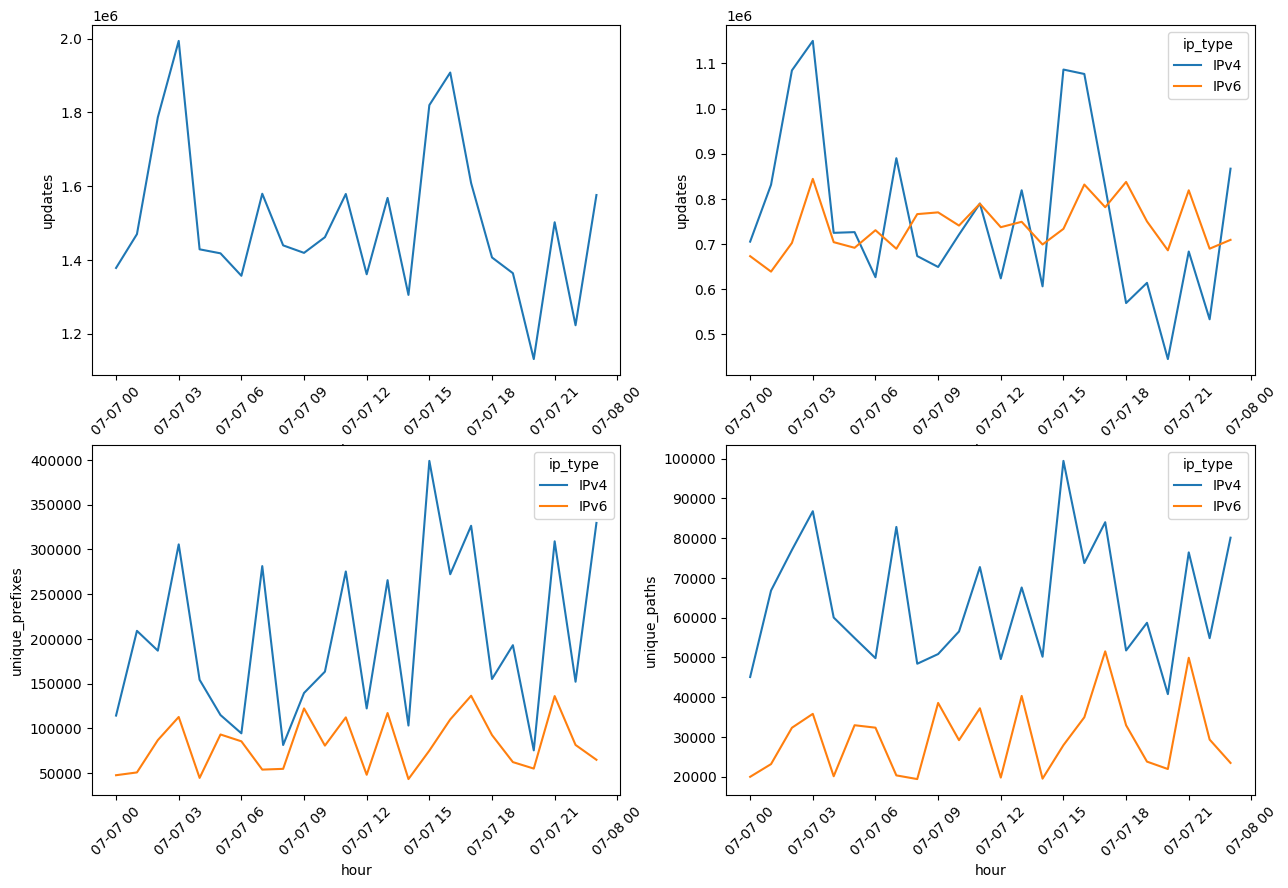

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


df_viz = df_hour_pd.groupby('hour')[['updates']].sum().reset_index()
ax = sns.lineplot(df_viz, x='hour', y='updates', ax=axs[0,0])
ax.tick_params(axis='x', labelrotation=45)

df_viz = df_hour_pd.groupby(['hour', 'ip_type'])[['updates']].sum().reset_index()
ax = sns.lineplot(df_viz, x='hour', y='updates', hue='ip_type', ax=axs[0,1])
ax.tick_params(axis='x', labelrotation=45)

df_viz = df_hour_pd.groupby(['hour', 'ip_type'])[['unique_prefixes']].sum().reset_index()
ax = sns.lineplot(df_viz, x='hour', y='unique_prefixes', hue='ip_type', ax=axs[1, 0])
ax.tick_params(axis='x', labelrotation=45)

df_viz = df_hour_pd.groupby(['hour', 'ip_type'])[['unique_paths']].sum().reset_index()
ax = sns.lineplot(df_viz, x='hour', y='unique_paths', hue='ip_type', ax=axs[1, 1])
ax.tick_params(axis='x', labelrotation=45)

## Origins, Peers and Pairs

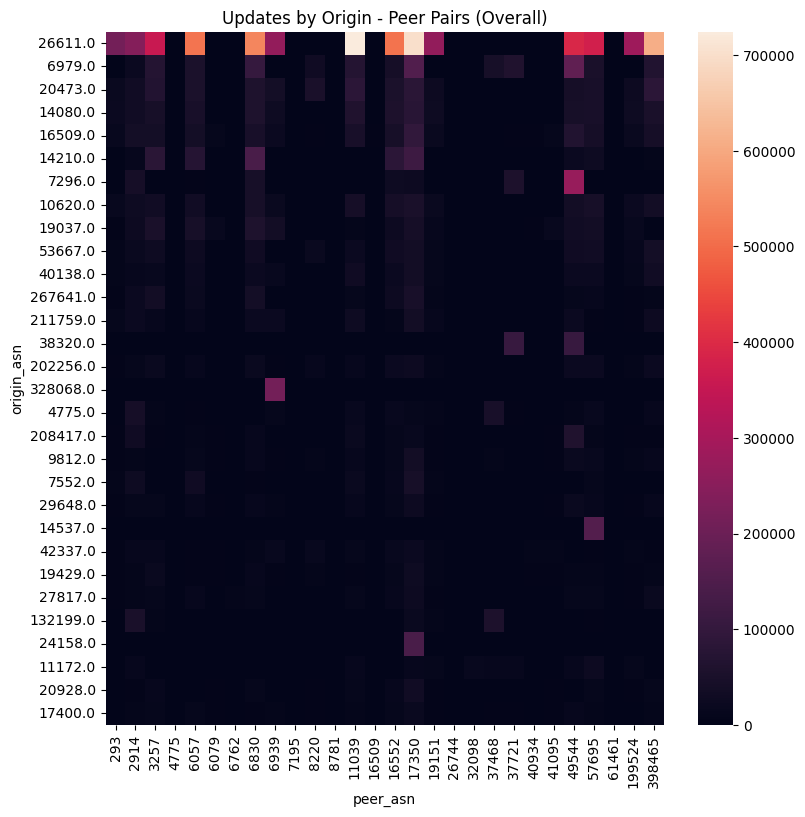

In [20]:
df_viz = df_hour_pd.pivot_table(index='origin_asn', columns='peer_asn', values='updates', aggfunc='sum')
df_viz['total'] = df_viz.sum(axis=1)
df_viz = df_viz.sort_values('total', ascending=False).drop(columns='total')
df_viz = df_viz.fillna(0)

fig = plt.figure(figsize=(9, 9))
ax = sns.heatmap(df_viz.head(30))
ax.set_title('Updates by Origin - Peer Pairs (Overall)')

origin_asn_sorted = df_viz.index

Text(0.5, 1.0, 'Updates by Origin - Peer Pairs (Overall) - 2')

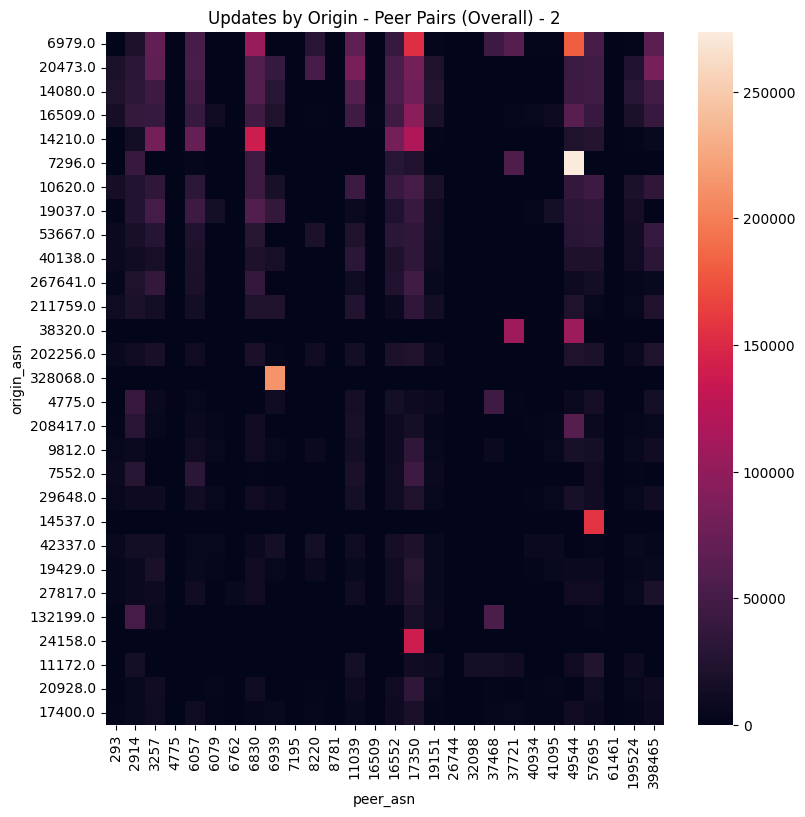

In [21]:
fig = plt.figure(figsize=(9, 9))
ax = sns.heatmap(df_viz.iloc[1:30])
ax.set_title('Updates by Origin - Peer Pairs (Overall) - 2')

Text(0.5, 1.0, 'Avg. Path Length by Origin - Peer Pairs (Overall)')

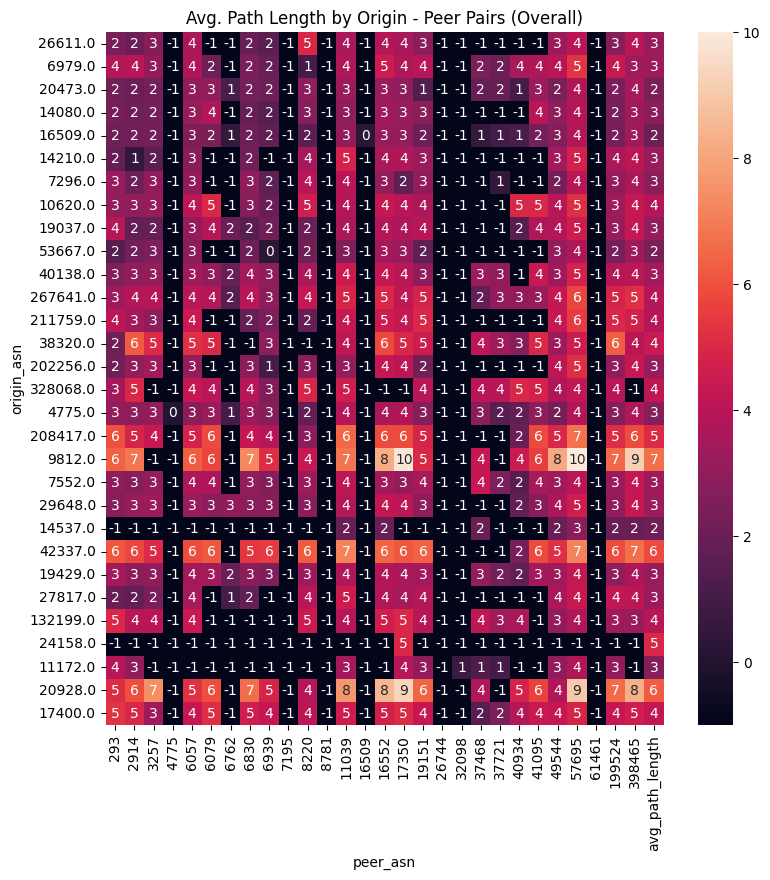

In [22]:
df_viz = df_hour_pd.pivot_table(index='origin_asn', columns='peer_asn', values='mean_path_length', aggfunc='mean')
df_viz['avg_path_length'] = df_viz.mean(axis=1)
df_viz = df_viz.loc[origin_asn_sorted]
df_viz = df_viz.fillna(-1)

fig = plt.figure(figsize=(9, 9))
ax = sns.heatmap(df_viz.head(30), annot=True, fmt='.0f')
ax.set_title('Avg. Path Length by Origin - Peer Pairs (Overall)')

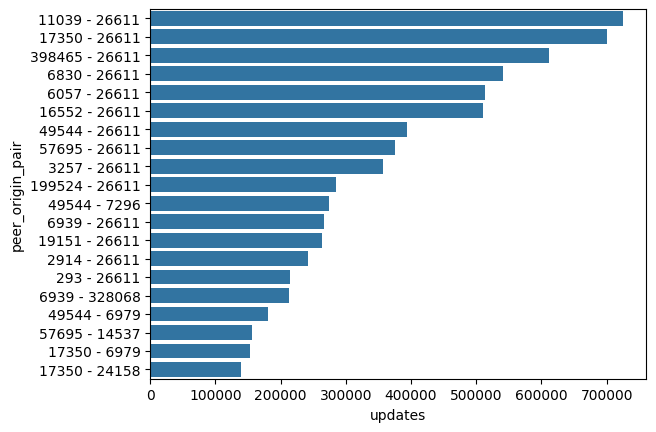

In [23]:
df_viz = df_hour_pd.groupby(['peer_asn', 'origin_asn'])[['updates']].sum().reset_index()
df_viz['peer_origin_pair'] = df_viz.apply(lambda x: f"{int(x['peer_asn'])} - {int(x['origin_asn'])}", axis=1)
df_viz = df_viz.sort_values('updates', ascending=False)
ax = sns.barplot(df_viz.iloc[:20], x='updates', y='peer_origin_pair')

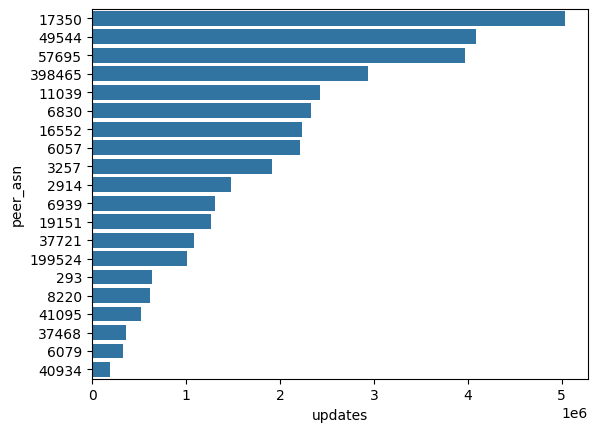

In [24]:
df_viz = df_hour_pd.groupby('peer_asn')[['updates']].sum().reset_index()
df_viz = df_viz.sort_values('updates', ascending=False)
df_viz = df_viz.astype({'peer_asn': str})
ax = sns.barplot(df_viz.head(20), x='updates', y='peer_asn')

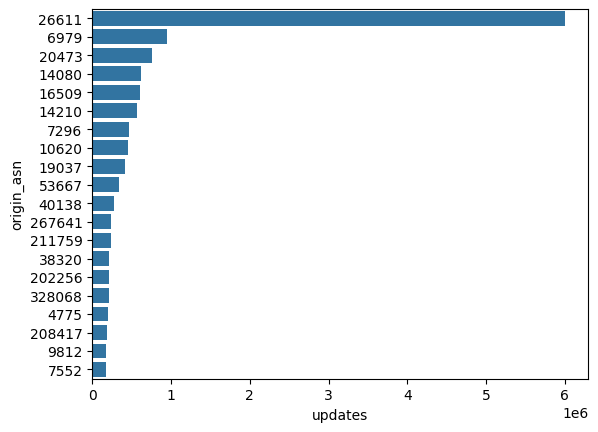

In [25]:
df_viz = df_hour_pd.groupby('origin_asn')[['updates']].sum().reset_index()
df_viz = df_viz.sort_values('updates', ascending=False)
df_viz = df_viz.astype({'origin_asn': int}).astype({'origin_asn': str})
ax = sns.barplot(df_viz.head(20), x='updates', y='origin_asn')